In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode EXPIRED 3 days ago

    Your usage of mkl is now out of compliance with the license agreement.
    A license for mkl can be purchased at: http://continuum.io
    


In [9]:
__author__ = 'nipunbatra'

import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv("../main_15min_decomposition_12_daily_weekly_cluster_diff_frac_temp_weekday.csv",index_col=0)
dfc = df.copy()

df = df.drop(871)
df = df.drop(1169)



w=df[['aggregate_%d' %i for i in range(1,13)]]

df = df.ix[w[w>0].dropna().index]

"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       #'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       #'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],}
                       #'disag_fridge':'disag_fridge'}
                       #'mins_hvac':'mins_hvac',}
                       #'month_extract':['variance','ratio_min_max', 'difference_min_max',
                        #                'ratio_difference_min_max']}

"""
features_individual = {'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       'trend_12':['stdev_trend_12','max_trend_12'],

                       'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],
                       'cluster_big':'cluster_big',
                       'cluster_small':'cluster_small',
                       'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'week':["fraction_%d" % i for i in range(1, 8)],
                       #'disag_fridge':'disag_fridge'}
                       'mins_hvac':'mins_hvac',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}

### Monthly ONLY
"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       #'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       #'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       #'trend_12':['stdev_trend_12','max_trend_12'],
                       #'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       #'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       #'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       #'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],}
                       #'disag_fridge':'disag_fridge'}
                       #'mins_hvac':'mins_hvac',
                       #'cluster_big':'cluster_big',
                       #'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}


"""

from itertools import combinations
features_dict = {}
for feature_size in range(1,max(4,len(features_individual))):
    combinations_size_n = list(combinations(features_individual.keys(), feature_size))
    for com in combinations_size_n:
        features_dict[com] = np.hstack([features_individual[x] for x in com]).tolist()



hvac_fhmm_pred = pd.read_csv("../fhmm_disag_new.csv", index_col=0)
fridge_fhmm_pred = pd.read_csv("../fridge_fhmm.csv", index_col=0)
appliance_fhmm = {'fridge': fridge_fhmm_pred,
                  'hvac': hvac_fhmm_pred}

national_average = {"fridge": 0.07, "hvac": 0.18, 'wm': 0.01, 'furnace': 0.09, 'dw': 0.02, 'dr': 0.04, 'light': .11}


def scale_0_1(ser, minimum=None, maximum=None):
    if minimum is not None:
        pass
    else:
        minimum = ser.min()
        maximum = ser.max()
    return (ser-minimum).div(maximum-minimum)

#Normalising features
max_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].max().max()
min_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].min().min()
df[["aggregate_%d" % i for i in range(1, 13)]] = scale_0_1(df[["aggregate_%d" % i for i in range(1, 13)]], min_aggregate, max_aggregate)


max_weekly = df[["daily_usage_%d" % i for i in range(1, 8)]].max().max()
min_weekly = df[["daily_usage_%d" % i for i in range(1, 8)]].min().min()
df[["daily_usage_%d" % i for i in range(1, 8)]] = scale_0_1(df[["daily_usage_%d" % i for i in range(1, 8)]], min_weekly, max_weekly)

df['area'] = scale_0_1(df['area'])

df['num_rooms'] = scale_0_1(df['num_rooms'])
df['total_occupants'] = scale_0_1(df['total_occupants'])
df['mins_hvac'] =  scale_0_1(df['mins_hvac'])

# Adding new feature
aa = df[["aggregate_%d" % i for i in range(1, 13)]].copy()
df['variance'] = df[["aggregate_%d" % i for i in range(1, 13)]].var(axis=1)
df['ratio_min_max'] = aa.min(axis=1)/aa.max(axis=1)


df['difference_min_max'] = aa.max(axis=1)-aa.min(axis=1)
df['ratio_difference_min_max'] = (aa.max(axis=1)-aa.min(axis=1)).div(aa.max(axis=1))


for col in ["stdev_trend_12","stdev_seasonal_12","max_seasonal_12","max_trend_12",
            "stdev_trend_daily","stdev_seasonal_daily","max_seasonal_daily","max_trend_daily",
            "stdev_trend_weekly","stdev_seasonal_weekly","max_seasonal_weekly","max_trend_weekly","disag_fridge",
            'stdev_trend','stdev_seasonal','max_seasonal','max_trend',
            'cluster_small','cluster_big', 'temperature_corr', 'variance',
            'ratio_min_max','ratio_difference_min_max']:
    if col in df.columns:

        df[col] = scale_0_1(df[col])



dfs = {}
total = features_dict.values()[np.array(map(len, features_dict.values())).argmax()]
for appliance in ['fridge','hvac','dr','light','dw','wm']:
    temp=df.ix[df[['%s_%d' %(appliance, i) for i in range(1,13)]].dropna().index]
    dfs[appliance] =temp.ix[temp[total].dropna().index]
    print appliance, len(dfs[appliance])

appliance_min = {'fridge':5,'hvac':5,'wm':0,'dw':0,'dr':0,'light':0}

all_homes = {
    'dw':[  94,  370,  545,  624, 2156, 2242, 2814, 2829, 3723,
            4767, 5357,6636, 6910, 7769, 9934],
    'wm':[  94,  370,  545,  624, 2156, 2242, 2814, 3367, 3456, 3723, 3967,
            5357, 7769, 9654, 9922, 9934],
    'hvac':[  26,   94,  370,  410,  545,  624, 1283, 1642, 1953, 2129,
            2156, 2242, 2470, 2814, 2829,  3367, 3456, 3723,
            3967, 4767, 5218, 5357, 5371, 5746, 5785, 5814, 6072,
            6636, 6836, 6910, 7731, 7769, 7866, 9609, 9654, 9922, 9933, 9934],
    'fridge':[  94,  370,  410,  545,  624, 1953, 2156, 2242, 2814, 2829, 3367,
            3456, 3723, 3967, 4767, 5357, 5371, 6072, 6636, 6910, 7769, 7866],
    'light':df.index.tolist(),
        #[ 624, 1334, 2814, 2925, 2986, 3367, 3456, 3482, 3723, 3967, 4732,
        #    4767, 5814, 5817, 6072, 6266, 6910, 7016, 7429, 7731, 7769, 7866,
        #    8317, 8626, 9052, 9654, 9922],
    'dr':[  94,  370,  410, 2156, 2242, 2814, 3456, 3723, 4767,
            5785, 5814, 6072, 6636, 6836, 7731, 7769, 7866, 9654, 9922,
            9933, 9982]
}

all_homes = {appliance:dfs[appliance].index for appliance in dfs.keys()}

all_homes['fridge'] = np.array(np.setdiff1d(all_homes['fridge'], [2233, 5746, 7016]))
all_homes['hvac'] = np.array(np.setdiff1d(all_homes['hvac'], [252, 2925, 2986, 3482, 4732, 5439, 6266,
                                                              8626, 1800, 2233, 5817, 7016, 7429, 8317,
                                                              9052, 9982]))

all_homes['dw'] =  np.array(np.setdiff1d(all_homes['dw'],[2233, 7016]))

all_homes['wm'] = np.array([  94,  370,  545,  624, 2156, 2242, 2470, 2814, 3367, 3456, 3723,
            3967, 5357, 7769, 9654, 9922, 9934])
all_homes['light']=[624, 1334, 3367, 3456, 3723, 5814, 6072, 6910, 7769, 7866, 9654,
            9922]

fridge 30
hvac 44
dr 32
light 21
dw 28
wm 26


In [5]:
features_individual = {'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       'trend_12':['stdev_trend_12','max_trend_12'],
                       'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],
                       'disag_fridge':'disag_fridge',
                       'mins_hvac':'mins_hvac',
                       'cluster_big':'cluster_big',
                       'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}

from itertools import combinations
features_dict = {}
for feature_size in range(1,max(4,len(features_individual))):
    combinations_size_n = list(combinations(features_individual.keys(), feature_size))
    for com in combinations_size_n:
        features_dict[com] = np.hstack([features_individual[x] for x in com]).tolist()


dfs = {}
total = features_dict.values()[np.array(map(len, features_dict.values())).argmax()]
for appliance in ['fridge','hvac','dr','light','dw','wm']:
    temp=df.ix[df[['%s_%d' %(appliance, i) for i in range(1,13)]].dropna().index]
    dfs[appliance] =temp.ix[temp[total].dropna().index]

In [6]:
df_appl = {appl:df.ix[all_homes[appl]].copy() for appl in ['fridge','hvac','dr','light','dw','wm']}

In [7]:
df_appl['wm'].head()

,aggregate_1,aggregate_2,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,...,daily_usage_5,daily_usage_6,daily_usage_7,area,num_rooms,total_occupants,variance,ratio_min_max,difference_min_max,ratio_difference_min_max
94,0.143181,0.081962,0.093821,0.080206,0.097667,0.153058,0.173016,0.109883,0.153402,0.089413,...,0.066107,0.112751,0.113335,0.296457,0.1,0.4,0.018453,0.455015,0.115180,0.544985
370,0.255465,0.230236,0.212220,0.217418,0.404339,0.617624,0.631348,0.880712,0.637119,0.426289,...,0.467673,0.485908,0.476523,0.677953,0.6,0.4,0.743571,0.327995,0.668492,0.672005
545,0.192407,0.182138,0.211784,0.191359,0.377628,0.628370,0.576113,0.720570,0.451861,0.332825,...,0.398431,0.381054,0.342233,0.584646,1.0,0.4,0.579947,0.279350,0.572690,0.720650
624,0.125368,0.037204,0.030524,0.040147,0.075879,0.162064,0.230569,0.216559,0.158095,0.083441,...,0.091036,0.111078,0.104143,0.448819,0.5,0.8,0.074003,0.180203,0.200045,0.819797
2156,0.225887,0.169340,0.275184,0.201350,0.306517,0.401904,0.367288,0.424180,0.326950,0.189589,...,0.274387,0.241768,0.260986,0.322835,0.5,0.4,0.110829,0.543406,0.254840,0.456594


In [8]:
import os
st = pd.HDFStore(os.path.expanduser("~/Downloads/wiki-temp.h5"))

### Homes with similar short term frequency decomposition have similar fridge usage

In [86]:
all_homes['fridge']

array([  26,   94,  370,  410,  545,  624, 1334, 1642, 1953, 2156, 2242,
       2814, 3367, 3456, 3482, 3723, 3967, 4767, 5357, 5371, 6072, 6636,
       6836, 6910, 7769, 7866, 9982])

In [95]:
temp = st['/%d' %home]['2013']

In [96]:
temp.columns

Index([u'lights_plugs2', u'lights_plugs3', u'dishwasher1', u'lights_plugs1',
       u'bedroom1', u'bedroom2', u'bedroom3', u'furnace2', u'drye1',
       u'disposal1', u'use', u'utilityroom1', u'furnace1', u'livingroom1',
       u'kitchen1', u'kitchen2', u'clotheswasher1', u'oven1', u'air1',
       u'air2'],
      dtype='object')

In [10]:
dfs_hvac = {}
for home in [26, 94, 370, 2814, 3367]:
    temp = st['/%d' %home]['2013'][['use','air1']].resample("15T")
    decomposed_df = decompose(temp['use'], freq=96*7)
    dfs_hvac[home] = pd.DataFrame({"hvac":temp['air1'], 
                                   'use':temp['use'],
                                     'seasonal':decomposed_df.seasonal, 
                                     'trend':decomposed_df.trend})

In [31]:
%matplotlib qt

In [36]:

dfs_hvac[370][['hvac', 'seasonal','use']]['2013-05-20':].head(500).plot(subplots=True,  figsize=(16,6))



array([<matplotlib.axes._subplots.AxesSubplot object at 0x13fe1b810>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13f117090>], dtype=object)

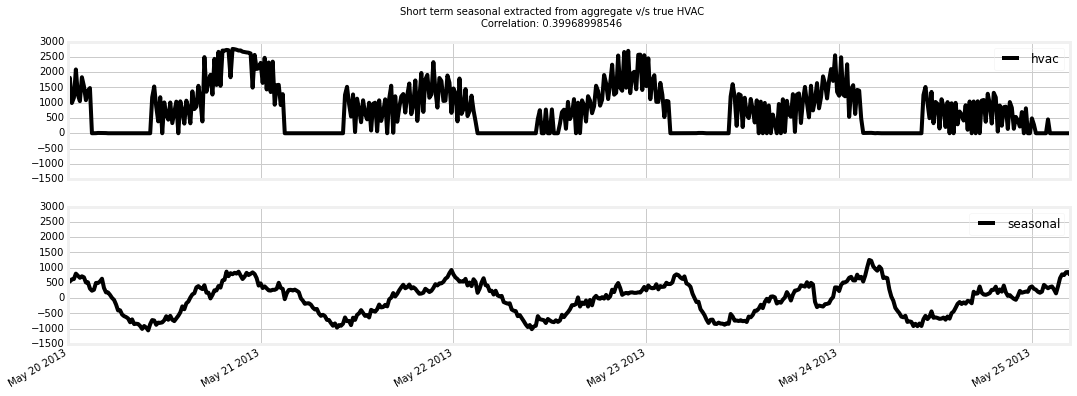

In [12]:
dfs_hvac[370][['hvac', 'seasonal']]['2013-05-20':].head(500).plot(subplots=True, figsize=(16,6))
plt.xlabel("")

corr = dfs_hvac[370][['hvac', 'seasonal']]['2013-05-20':'2013-10-30'].corr().values[0, 1]
plt.suptitle("Short term seasonal extracted from aggregate v/s true HVAC\nCorrelation: "+str(corr))
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/hvac_seasonal_aggregate_370.png")

In [23]:
dfs_hvac[26].sum()
s = dfs_hvac[26]['seasonal']
s-=s.min()

In [25]:
s.sum()
dfs_hvac[26].sum()

hvac        12969590.534972
seasonal    33236305.892454
trend       44090664.874186
dtype: float64

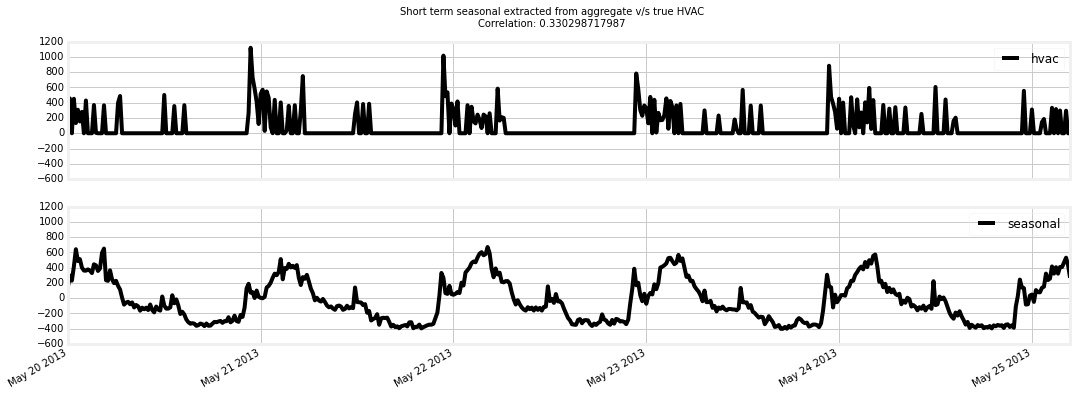

In [185]:
dfs_fridge[94][['hvac', 'seasonal']]['2013-05-20':].head(500).plot(subplots=True, sharey=True, figsize=(16,6))
plt.xlabel("")
corr = dfs_fridge[94][['hvac', 'seasonal']]['2013-05-20':'2013-10-30'].corr().values[0, 1]
plt.suptitle("Short term seasonal extracted from aggregate v/s true HVAC\nCorrelation: "+str(corr))
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/hvac_seasonal_aggregate_94.png")

In [10]:
def plot_correlations(df, appliance, feature):
    months = ["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    df = df.ix[all_homes[appliance]]
    if appliance is not "hvac":
        fig, ax = plt.subplots(ncols=6, nrows=2, sharey=True, sharex=True, figsize=(16,6))
        for month in range(1, 13):
            ax[(month-1)/6, (month-1)%6].scatter(df[feature],df['%s_%d' %(appliance, month)])
            ax[(month-1)/6, (month-1)%6].set_title(df[[feature, '%s_%d' %(appliance, month)]].corr().values[0, 1])
            ax[(month-1)/6, (month-1)%6].set_xlabel(months[month-1])
        ax[0,0].set_ylabel("Energy (kWh)")
        ax[1,0].set_ylabel("Energy (kWh)")
    else:
        fig, ax = plt.subplots(ncols=6, nrows=1, sharey=True, sharex=True, figsize=(16,3))
        for month in range(5, 11):
            ax[month-5].scatter(df[feature],df['%s_%d' %(appliance, month)])
            ax[month-5].set_title(df[[feature, '%s_%d' %(appliance, month)]].corr().values[0, 1])
            ax[month-5].set_xlabel(months[month-1])
        ax[0].set_ylabel("Energy (kWh)")
    plt.tight_layout()

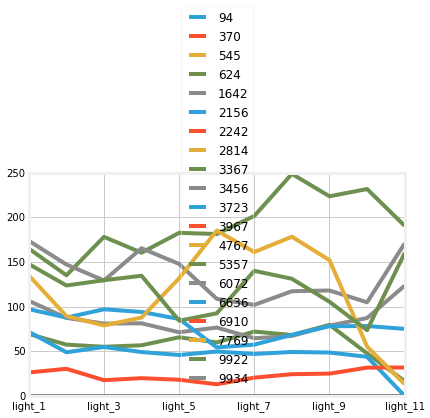

In [90]:
df_appl[appliance][['light_%d' %i for i in range(1,12)]].T.plot()

In [21]:
df_appl[appliance][(df_appl[appliance][['light_%d' %i for i in range(1,12)]]>0).sum(axis=1)>10].index

Int64Index([624, 1334, 3367, 3456, 3723, 5814, 6072, 6910, 7769, 7866, 9654,
            9922],
           dtype='int64')

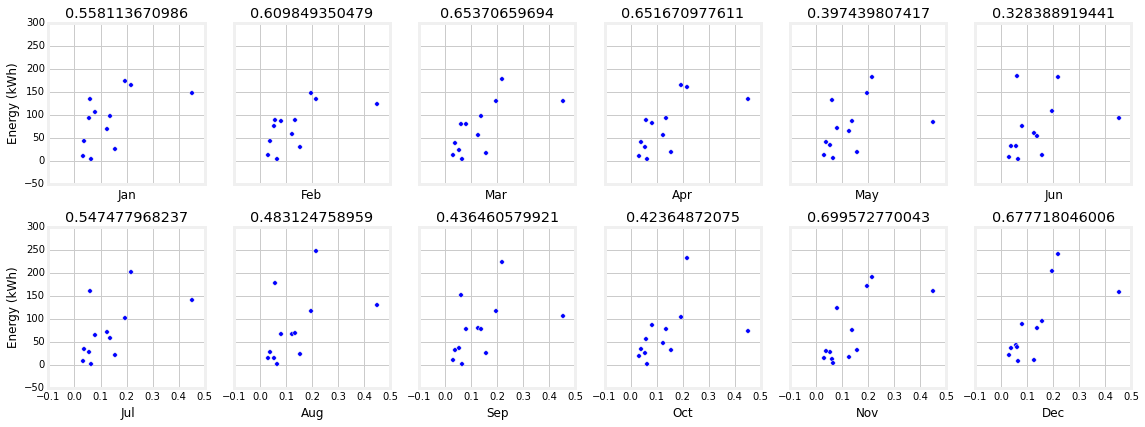

In [12]:
appliance="light"
feature='aggregate_1'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

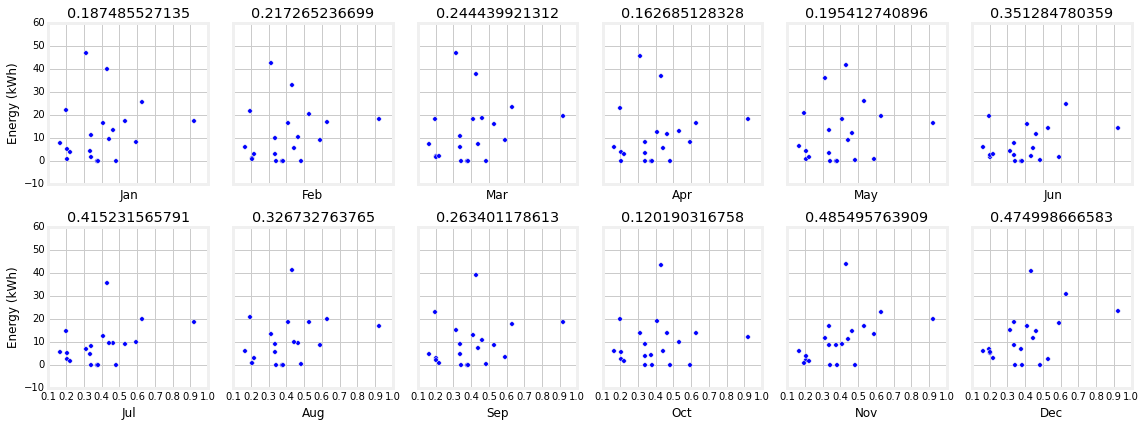

In [94]:
appliance="dw"
feature='daily_usage_7'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

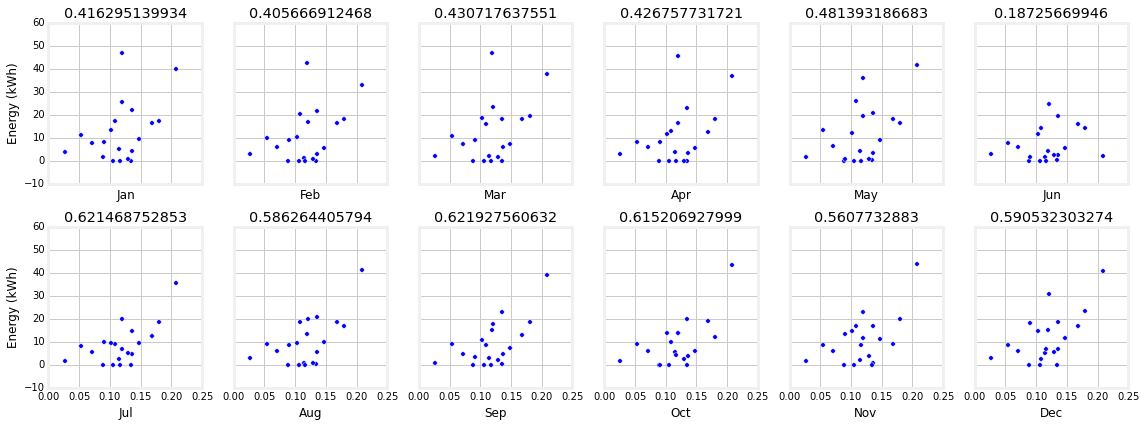

In [106]:
appliance="dw"
feature='bet_500_1000'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

In [79]:
df_appl[appliance][['dw_%d' %i for i in range(1,13)]]

,dw_1,dw_2,dw_3,dw_4,dw_5,dw_6,dw_7,dw_8,dw_9,dw_10,dw_11,dw_12
26,0.000000,0.000000,0.000000,0.000000,0.000000,0.016388,0.000000,0.000000,0.000000,0.000000,7.803561,10.590423
94,4.952780,1.057893,1.950852,3.959691,4.389723,1.520633,2.478787,0.650335,3.094085,5.392383,2.304401,5.248410
370,17.213707,20.517046,15.906662,12.860926,26.143587,14.351757,9.246793,18.579844,8.787317,9.723796,16.967937,2.651677
545,16.552017,16.468393,18.124889,12.492145,18.027090,15.841501,12.629250,18.679277,13.180611,19.250902,8.898735,17.108036
624,22.189878,21.830500,18.257030,22.835896,20.888189,19.280806,14.738457,20.943541,22.902519,20.136959,0.869890,6.689891
1334,10.351249,7.275694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1642,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.449512,8.443628,6.983821
2156,4.201601,2.965667,6.010877,3.437706,3.560072,2.422517,4.511919,5.490371,4.515115,3.994235,17.069445,18.638239
2242,25.609072,16.899548,23.375969,16.558443,19.654873,24.672611,19.881144,19.933605,17.827288,13.819488,23.044249,30.805292
2814,13.460243,10.403151,18.655682,11.837610,11.864521,11.676807,9.647058,9.599985,11.018278,13.756163,14.513444,14.530733


In [15]:
all_homes["wm"][0]

94

In [97]:
g = {}
for home in all_homes["dw"][:]:
    print home
    temp_df = st['%d' %home]['2013'][['dishwasher1']]
    temp_df["dayofweek"] = temp_df.index.dayofweek
    piv = pd.pivot_table(temp_df, index=["dayofweek"])
    g[home] = piv.div(piv.sum()).values.flatten()

94
370
545
624
1642
2156
2242
2814
3367
3456
3723
3967
4767
5357
6072
6636
6910
7769
9922
9934


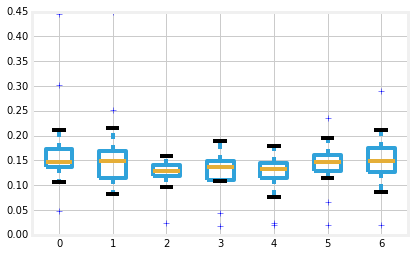

In [104]:
pd.DataFrame(g).T.plot(kind='box')

In [30]:
temp_df = st['%d' %home]['2013']

In [31]:
temp_df

,lights_plugs2,lights_plugs3,dishwasher1,lights_plugs1,lights_plugs6,lights_plugs4,lights_plugs5,bedroom1,drye1,range1,...,use,unknown3,furnace1,clotheswasher1,refrigerator1,oven1,car1,waterheater1,air1,unknown1
localminute,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00-06:00,4,30,0,0,6,0,0,0,0,0,...,185,0,14,0,3,0,0,0,42,0
2013-01-01 00:01:00-06:00,4,30,0,0,6,0,0,0,0,0,...,186,0,14,0,3,0,0,0,42,0
2013-01-01 00:02:00-06:00,4,30,0,0,6,0,0,0,0,0,...,185,0,14,0,3,0,0,0,42,0
2013-01-01 00:03:00-06:00,4,30,0,0,6,0,0,0,0,0,...,185,0,14,0,3,0,0,0,42,0
2013-01-01 00:04:00-06:00,4,30,0,0,6,0,0,0,0,0,...,185,0,14,0,3,0,0,0,42,0
2013-01-01 00:05:00-06:00,4,30,0,0,6,0,0,0,0,0,...,185,0,14,0,3,0,0,0,42,0
2013-01-01 00:06:00-06:00,4,30,0,0,6,0,0,0,0,0,...,185,0,14,0,3,0,0,0,42,0
2013-01-01 00:07:00-06:00,4,30,0,0,6,0,0,0,0,0,...,185,0,14,0,3,0,0,0,42,0
2013-01-01 00:08:00-06:00,4,30,0,0,6,0,0,0,0,0,...,185,0,14,0,3,0,0,0,42,0


In [52]:
o = {}
for home in all_homes["light"][:]:
    print home
    t_df = st['%d' %home]['2013']
    temp_df = t_df[['lights_plugs1']]
    if 'lights_plugs2' in t_df.columns:
        temp_df = temp_df + t_df['lights_plugs2']
    if 'lights_plugs3' in t_df.columns:
        temp_df = temp_df + t_df['lights_plugs3']
    if 'lights_plugs4' in t_df.columns:
        temp_df = temp_df + t_df['lights_plugs4']
    if 'lights_plugs5' in t_df.columns:
        temp_df = temp_df + t_df['lights_plugs5']
    if 'lights_plugs6' in t_df.columns:
        temp_df = temp_df + t_df['lights_plugs6']
    
    
    temp_df["hourofday"] = temp_df.index.hour
    piv = pd.pivot_table(temp_df, index=["hourofday"])
    o[home] = piv.div(piv.sum()).values.flatten()

    
    

624
1334
3367
3456
3723
5814
6072
6910
7769
7866
9654
9922


/Users/nipunbatra/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


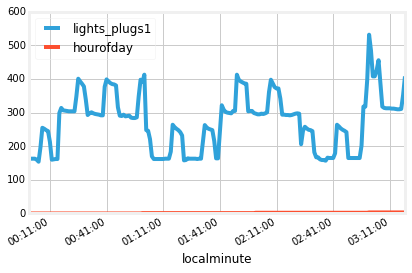

In [60]:
temp_df.head(200).plot()

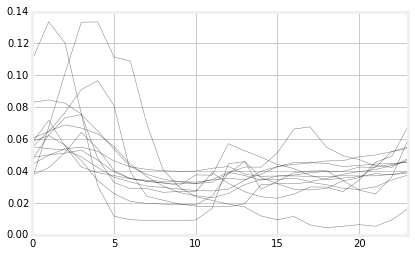

In [57]:
pd.DataFrame(o).plot(alpha=0.5, color='k',legend=False, linewidth=0.5)

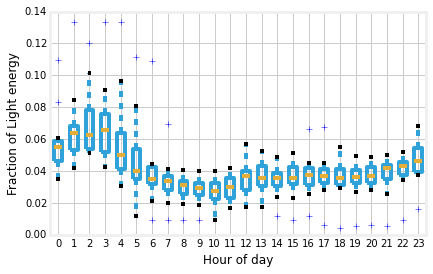

In [91]:
pd.DataFrame(o).T.plot(kind="box")
plt.ylabel("Fraction of Light energy")
plt.xlabel('Hour of day')

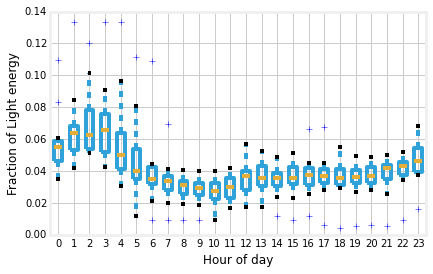

In [34]:
pd.DataFrame(o).T.plot(kind="box")
plt.ylabel("Fraction of Light energy")
plt.xlabel('Hour of day')
#plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/wm_day.png")

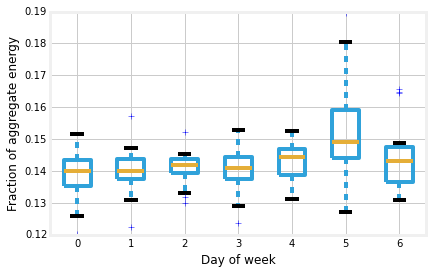

In [73]:
pd.DataFrame(g).T.plot(kind="box")
plt.ylabel("Fraction of aggregate energy")
plt.xlabel('Day of week')
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/aggregate_day.png")

In [22]:
pd.DataFrame(g).T[[6]].corrwith(pd.DataFrame(o).T[[6]])

6    0.66924
dtype: float64

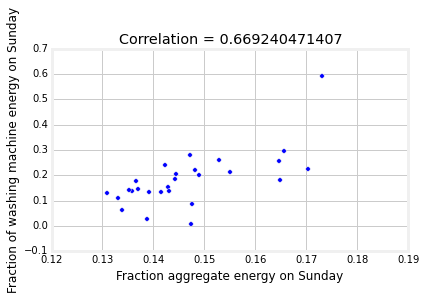

In [23]:
plt.scatter(pd.DataFrame(g).T[[6]],pd.DataFrame(o).T[[6]])
plt.xlabel("Fraction aggregate energy on Sunday")
plt.ylabel("Fraction of washing machine energy on Sunday")
plt.title("Correlation = "+str(pd.DataFrame(g).T[[6]].corrwith(pd.DataFrame(o).T[[6]]).values[0]))
plt.tight_layout()
#plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/wm_aggregate_correlation.png")

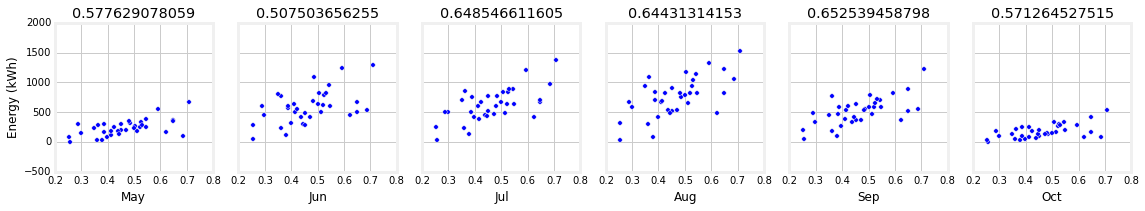

In [191]:
appliance="hvac"
feature='autocorr'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

In [217]:
temp = (df_appl['hvac'][['hvac_%d' %i for i in range(1, 13)]]-df_appl['hvac'].ix[370][['hvac_%d' %i for i in range(1, 13)]]).abs().sum(axis=1)
temp = temp.drop(370)
temp.sort()
temp.head(5)

2814    333.353115
3367    412.534132
545     573.549753
2129    656.146658
1283    897.211371
dtype: float64

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(16, 6))
dfs_hvac[370]['trend'][:].plot(ax=ax,label="370")
dfs_hvac[94]['trend'][:].plot(ax=ax, label="94")
dfs_hvac[2814]['trend'][:].plot(ax=ax, label="2814")
dfs_hvac[3367]['trend'][:].plot(ax=ax, label="3367")

plt.legend()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/hvac_trend.png", bbox_inches="tight")
plt.xlabel("")

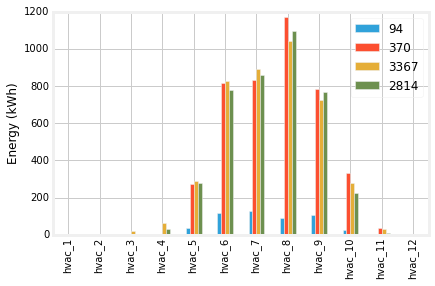

In [243]:
df_appl["hvac"].ix[[94, 370, 3367, 2814]][['hvac_%d' %i for i in range(1, 13)]].T.plot(kind="bar")
plt.ylabel("Energy (kWh)")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/hvac_trend_gt.png")

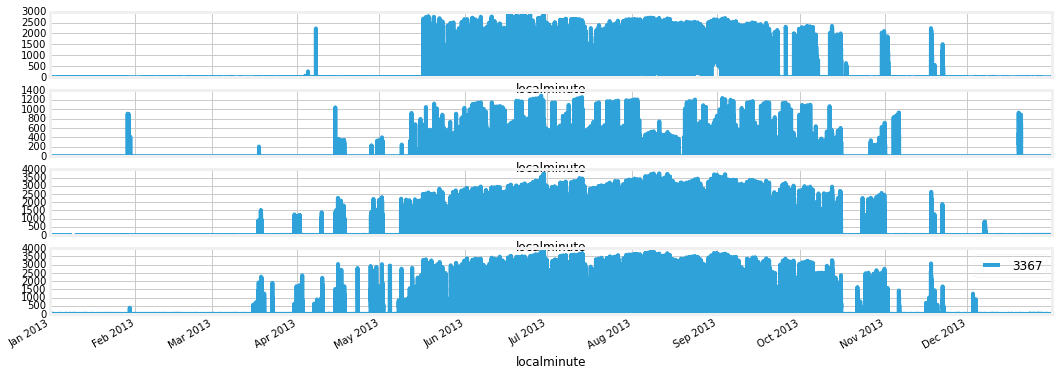

In [235]:
fig, ax = plt.subplots(sharex=True, nrows=4, figsize=(16,6))
dfs_hvac[370]['hvac'][:].plot(ax=ax[0],label="370")
dfs_hvac[94]['hvac'][:].plot(ax=ax[1], label="94")
dfs_hvac[2814]['hvac'][:].plot(ax=ax[2], label="2814")
dfs_hvac[3367]['hvac'][:].plot(ax=ax[3], label="3367")


plt.legend()

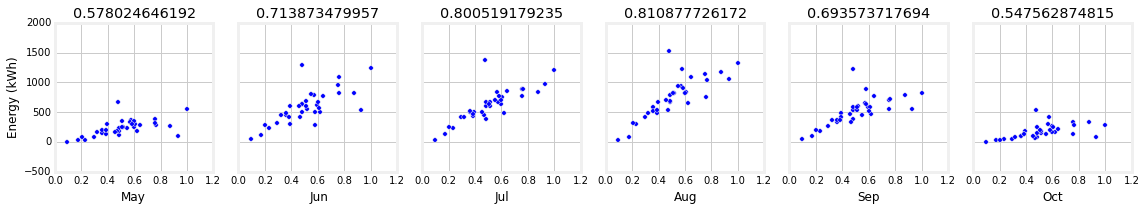

In [195]:
appliance="hvac"
feature='stdev_trend_weekly'
plot_correlations(df_appl[appliance], appliance, feature)
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/%s_%s.png" %(appliance, feature), bbox_inches="tight")

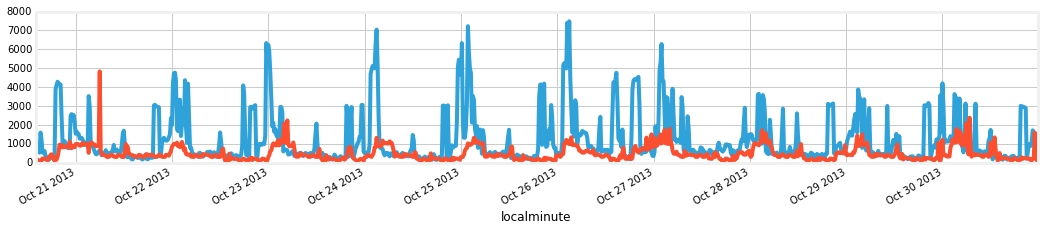

In [194]:
st['/26']['2013-05-01':'2013-10-30']['use'].resample("15T").tail(1000).plot(figsize=(16,3))
st['/94']['2013-05-01':'2013-10-30']['use'].resample("15T").tail(1000).plot(figsize=(16,3))



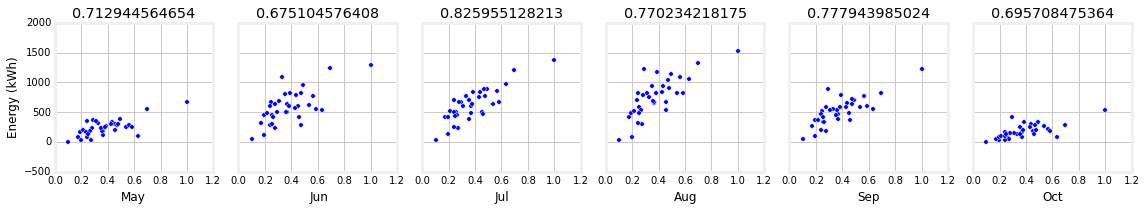

In [141]:
plot_correlations(df_appl['hvac'], 'hvac', 'stdev_seasonal_weekly')

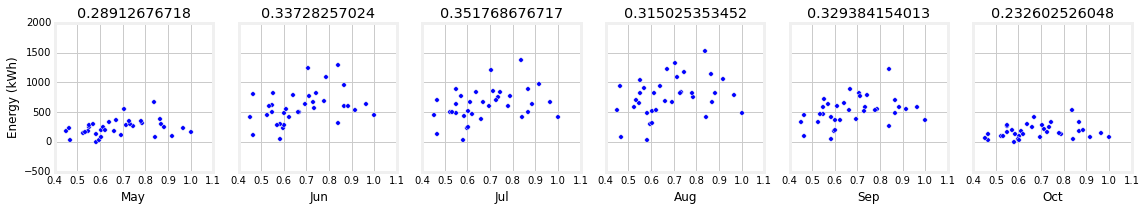

In [158]:
plot_correlations(df_appl['hvac'], 'hvac', 'temperature_corr')

In [ ]:
decompose()

In [26]:
import numpy as np

from scipy.special import gamma,psi
from scipy import ndimage
from scipy.linalg import det
from numpy import pi

from sklearn.neighbors import NearestNeighbors

__all__=['entropy', 'mutual_information', 'entropy_gaussian']

EPS = np.finfo(float).eps


def nearest_distances(X, k=1):
    '''
    X = array(N,M)
    N = number of points
    M = number of dimensions
    returns the distance to the kth nearest neighbor for every point in X
    '''
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    d, _ = knn.kneighbors(X) # the first nearest neighbor is itself
    return d[:, -1] # returns the distance to the kth nearest neighbor


def entropy_gaussian(C):
    '''
    Entropy of a gaussian variable with covariance matrix C
    '''
    if np.isscalar(C): # C is the variance
        return .5*(1 + np.log(2*pi)) + .5*np.log(C)
    else:
        n = C.shape[0] # dimension
        return .5*n*(1 + np.log(2*pi)) + .5*np.log(abs(det(C)))


def entropy(X, k=1):
    ''' Returns the entropy of the X.
    Parameters
    ===========
    X : array-like, shape (n_samples, n_features)
        The data the entropy of which is computed
    k : int, optional
        number of nearest neighbors for density estimation
    Notes
    ======
    Kozachenko, L. F. & Leonenko, N. N. 1987 Sample estimate of entropy
    of a random vector. Probl. Inf. Transm. 23, 95-101.
    See also: Evans, D. 2008 A computationally efficient estimator for
    mutual information, Proc. R. Soc. A 464 (2093), 1203-1215.
    and:
    Kraskov A, Stogbauer H, Grassberger P. (2004). Estimating mutual
    information. Phys Rev E 69(6 Pt 2):066138.
    '''

    # Distance to kth nearest neighbor
    r = nearest_distances(X, k) # squared distances
    n, d = X.shape
    volume_unit_ball = (pi**(.5*d)) / gamma(.5*d + 1)
    '''
    F. Perez-Cruz, (2008). Estimation of Information Theoretic Measures
    for Continuous Random Variables. Advances in Neural Information
    Processing Systems 21 (NIPS). Vancouver (Canada), December.
    return d*mean(log(r))+log(volume_unit_ball)+log(n-1)-log(k)
    '''
    return (d*np.mean(np.log(r + np.finfo(X.dtype).eps))
            + np.log(volume_unit_ball) + psi(n) - psi(k))


def mutual_information(variables, k=1):
    '''
    Returns the mutual information between any number of variables.
    Each variable is a matrix X = array(n_samples, n_features)
    where
      n = number of samples
      dx,dy = number of dimensions
    Optionally, the following keyword argument can be specified:
      k = number of nearest neighbors for density estimation
    Example: mutual_information((X, Y)), mutual_information((X, Y, Z), k=5)
    '''
    if len(variables) < 2:
        raise AttributeError(
                "Mutual information must involve at least 2 variables")
    all_vars = np.hstack(variables)
    return (sum([entropy(X, k=k) for X in variables])
            - entropy(all_vars, k=k))


def mutual_information_2d(x, y, sigma=1, normalized=False):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float
        the computed similariy measure
    """
    bins = (256, 256)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi



In [30]:
X = df_appl['hvac']['autocorr'].values.reshape(-1,1)
X = df_appl['hvac']['aggregate_9'].values.reshape(-1,1)


Y = df_appl['hvac']['hvac_9'].values.reshape(-1,1)
mutual_information((X, Y), k=5)

-5.0437270126384792